# Assignment 1

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import math
import time

global seed
seed = 123456

def initialize_parameters(layer_dims):
    """
    This function initialize the weight matrix according to Layer_dims.
    We modify a bit the random by pulling it closer to 0 in order to help the network to convarge faster.
    :param Layer_dims: an array of the dimensions of each layer in the network.
    :return: a dictionary containing the initialized W and b parameters of each layer
    """
    layers = len(layer_dims)
    weight_matrix = {}
    for i in np.arange(1, layers):
        cur_W = np.random.randn(layer_dims[i], layer_dims[i - 1]) / np.sqrt(layer_dims[i - 1])  # for better initialization
        cur_b = np.zeros((layer_dims[i], 1))
        
        weight_matrix["W" + str(i)] = cur_W
        weight_matrix["b" + str(i)] = cur_b
        
    return weight_matrix


def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation
    :param A: activation output
    :param W: weight matrix
    :param b: bias
    :return: Z: linear clculation of the input.
             linear_cache: cache data for later.
    """
    Z = np.dot(W, A) + b

    return Z, (A, W, b)


def softmax(Z):
    """
    calculates the softmax function of Z
    :param Z: the linear component of the activation function
    :return: A: the activations of the layer
             activation_cache – returns Z
    """
    exps = np.exp(Z)
    sums = sum(exps)
    A = exps / sums
    
    return A, Z


def relu(Z):
    """
    calculates the relu function of Z
    :param Z: the linear component of the activation function
    :return: A: the activations of the layer
             activation_cache – returns Z
    """
    A = np.maximum(0, Z)
    activation_cache = Z
    
    return A, activation_cache


def linear_activation_forward(A_prev, W, B, activation, use_batchnorm=False, dropout_threshold=0.):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer
    :param A_prev: activations of the previous layer
    :param W: the weights matrix of the current layer
    :param B: the bias vector of the current layer
    :param activation: the activation function to be used
    :return:A – the activations of the current layer
            cache – a joint dictionary containing both linear_cache and activation_cache
    """
    Z, linear_cache = linear_forward(A_prev, W, B)
    
    if activation == "softmax":
        A, activation_cache = softmax(Z)
    if activation == "relu":
        A, activation_cache = relu(Z)
        
    if use_batchnorm:
        A = apply_batchnorm(A)
        
    # Dropout
    scale = 1./(1.-dropout_threshold)
    dropout_matrix = np.random.binomial(1, 1.-dropout_threshold, size=A.shape)
    A *= dropout_matrix
    A *= scale
    linear_cache = linear_cache + (dropout_matrix, ) # appends to tuple

    return A, (linear_cache, activation_cache)


def L_model_forward(X, parameters, use_batchnorm=False, dropout_threshold=0.):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX computation
    :param X: the data, numpy array of shape (input size, number of examples)
    :param parameters: the initialized W and b parameters of each layer
    :param use_batchnorm: a boolean flag used to determine whether to apply batchnorm after
                            the activation
    :return: AL: the last post-activation value
             caches: a list of all the cache objects generated by the linear_forward function
    """
    A = X
    num_layers = len(parameters) // 2 # //2 because it includes biases
    caches = []
    
    for i in np.arange(1, num_layers):
        A, cache = linear_activation_forward(A, parameters["W" + str(i)], parameters["b" + str(i)], 'relu', use_batchnorm=use_batchnorm, dropout_threshold=dropout_threshold)
        caches.append(cache)
    
    # Output layer
    AL, cache = linear_activation_forward(A, parameters["W" + str(num_layers)], parameters["b" + str(num_layers)], 'softmax', use_batchnorm=False, dropout_threshold=0.)
    caches.append(cache)
    
    return AL, caches


def compute_cost(AL, Y):
    """
    Implement the categorical cross entropy cost function.
    :param AL: probability vector corresponding to your label predictions
    :param Y: the ground truth labels vector
    :return: cost: the cross-entropy cost
    """
    cost = (-np.sum(np.sum(Y * np.log(AL + 1e-13), axis=0))) / AL.shape[1]
    return cost


def apply_batchnorm(A):
    """
    performs batchnorm on the received activation values of a given layer.
    :param A: the activation values of a given layer
    :return: NA: the normalized activation values
    """
    A = A.T
    
    # mean calculations
    N = A.shape[0]
    mu = 1./N * np.sum(A, axis = 0)
    xmu = A - mu
    
    # variance and std calculations
    sq = xmu ** 2
    var = 1./N * np.sum(sq, axis = 0)
    sqrtvar = np.sqrt(var + np.exp(-8))
    ivar = 1./sqrtvar
    
    # output
    xhat = xmu * ivar
    NA = xhat.T

    return NA


def Linear_backward(dZ, cache):
    """
    Implements the linear part of the backward propagation process for a single layer
    :param dZ: the gradient of the cost with respect to the linear output of the current layer
    :param cache: tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    :return: dA_prev: Gradient of the cost with respect to the activation
             dW: Gradient of the cost with respect to W
             db: Gradient of the cost with respect to b
    """

    A_prev, W, b, dropout_matrix = cache
    num_examples = A_prev.shape[1]
    
    dA_prev = np.dot(W.T, dZ)
    dW = np.dot(dZ, A_prev.T) / num_examples
    db = np.sum(dZ, axis=1, keepdims=True) / num_examples

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation, dropout_threshold=0.):
    """
    Implements the backward propagation for the LINEAR->ACTIVATION layer. The function
    first computes dZ and then applies the linear_backward function.
    :param dA: post activation gradient of the current layer
    :param cache: contains both the linear cache and the activations cache
    :param activation: string that clarify the activation function used
    :return: dA_prev: Gradient of the cost with respect to the activation
             dW: Gradient of the cost with respect to W
             db: Gradient of the cost with respect to b
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)

    if activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
    
    # Dropout backprop
    dropout_matrix = linear_cache[3]
    scale = 1./(1.-dropout_threshold)
    dZ = dZ * dropout_matrix * scale
    
    dA_prev, dW, db = Linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    """
    Implements backward propagation for a ReLU unit
    :param dA: the post-activation gradient
    :param activation_cache: contains Z
    :return: dZ: gradient of the cost with respect to Z
    """
    dZ, x = None, activation_cache
    dZ = dA * (x >= 0)
    return dZ
  

def softmax_backward(dA, activation_cache):
    pass


def L_model_backward(AL, Y, caches, dropout_threshold=0.):
    """
    Implement the backward propagation process for the entire network.
    :param AL: the probabilities vector, the output of the forward propagation
    :param Y: the true labels vector
    :param caches: list of caches containing for each layer
    :return: Grads: a dictionary with the gradients
    """
    Grads = {}
    cLayers = len(caches)
    Y = Y.reshape(AL.shape)

    curr_cache = caches[-1]
    dAL = AL - Y # derivative of the loss + softmax
    
    Grads["dA" + str(cLayers)], Grads["dW" + str(cLayers)], Grads["db" + str(cLayers)] = Linear_backward(dAL, curr_cache[0])

    for i in reversed(range(cLayers - 1)):
        curr_cache = caches[i]
        dA_prev, dW, db = linear_activation_backward(Grads["dA" + str(i + 2)], curr_cache, "relu", dropout_threshold=dropout_threshold)
        Grads["dA" + str(i + 1)] = dA_prev
        Grads["dW" + str(i + 1)] = dW
        Grads["db" + str(i + 1)] = db

    return Grads


def Update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters using gradient descent
    :param parameters: a python dictionary containing the DNN architecture’s parameters
    :param grads: a python dictionary containing the gradients
    :param learning_rate: the learning rate used to update the parameters
    :return: parameters: the updated values of the parameters object provided as input
    """
    cLayers = len(parameters) // 2

    for l in range(cLayers):
        parameters["W" + str(l + 1)] -= learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] -= learning_rate * grads["db" + str(l + 1)]

    return parameters


def L_layer_model(X, Y, layers_dims, num_iterations, learning_rate=0.009, batch_size=128, use_batchnorm=False, early_stopping=100, dropout_threshold=0., min_epochs=10):
  
    np.random.seed(seed)
    
    x_train, x_val, y_train, y_val = [elem.T for elem in train_test_split(X.T, Y.T, test_size=0.2, random_state=seed)]

    parameters = initialize_parameters(layers_dims)
    num_examples = x_train.shape[1]
    num_batches = math.ceil(num_examples / batch_size)
    train_loss = []
    full_train_loss = []
    val_loss = []
    params_container = []
    to_stop = False
    i=0
    
    for epoch in range(num_iterations):
      
        t0 = time.time()
        acc_full_epoch = []
        
        for (curr_batch_x, curr_batch_y) in create_batches(x_train, y_train, batch_size):
            i += 1
            
            # Training process
            AL, caches = L_model_forward(curr_batch_x, parameters, use_batchnorm, dropout_threshold=dropout_threshold)
            Grads = L_model_backward(AL, curr_batch_y, caches, dropout_threshold=dropout_threshold)
            parameters = Update_parameters(parameters, Grads, learning_rate)
            
            # Costs-related
            cost = compute_cost(AL, curr_batch_y)
            full_train_loss.append(cost)
            if (i % 100 == 0):
                train_loss.append(cost)
                
            params_container.append(parameters)

            acc_full_epoch.append(acc_metric(curr_batch_y, AL))
            
            # Validation set evaluation
            if val_every_epoch:
                to_stop, probas_val, params_container, val_loss = evaluate_validation(x_val, y_val, parameters, use_batchnorm, val_loss, params_container, min_epochs, epoch)
            
            if to_stop:
                break
        
        t1 = time.time()
        # end batch for
        
        if not val_every_epoch:
            _, probas_val, params_container, val_loss = evaluate_validation(x_val, y_val, parameters, use_batchnorm, val_loss, params_container, min_epochs, epoch)
        
        loss_tr = round(np.mean(full_train_loss[-num_batches:]), 4)
        loss_v = round(val_loss[-1], 4)
        acc_tr = round(np.mean(acc_full_epoch) * 100, 2)
        acc_val = round(acc_metric(y_val, probas_val) * 100, 2)
        
        print("Epoch #{} in: {:.0f}s | train_loss: {} - val_loss: {} | train_acc: {} - val_acc: {}".format(epoch+1, t1-t0, loss_tr, loss_v, acc_tr, acc_val))
        
        if to_stop:
            parameters = params_container[0]
            print('Early stopping...')
            break
          
    # end epoch for
    
    print('Training process has completed after {} iterations and {} epochs.'.format(i, epoch+1))
    
    return parameters, train_loss

  
def evaluate_validation(x_val, y_val, parameters, use_batchnorm, val_loss, params_container, min_epochs, curr_epoch):
    """
    Handles the evaluation of the validation set after every epoch.
    Implements and supports the early stopping mechanism.
    """
    probas_val, _ = L_model_forward(x_val, parameters, use_batchnorm=use_batchnorm)
    cost_val = compute_cost(probas_val, y_val)
    val_loss.append(cost_val)
    
    epsilon = 0.001
    val_loss_copy = np.array(val_loss, copy=True)
    val_loss_copy[1:] += epsilon
    
    val_loss = val_loss[-100:] if len(val_loss) > 100 else val_loss
    params_container = params_container[-100:] if len(params_container) > 100 else params_container
    
    to_stop = False
    
    if curr_epoch >= min_epochs and len(val_loss_copy) >= 100 and np.argmin(val_loss_copy) == 0:
            to_stop = True
            
    return to_stop, probas_val, params_container, val_loss
        

def Predict(X, Y, parameters, use_batchnorm=False):
    """
    The function receives an input data and the true labels and calculates the accuracy of
    the trained neural network on the data.
    :param X: the input data
    :param Y: the “real” labels of the data
    :param parameters: a python dictionary containing the DNN architecture’s parameters
    :return: accuracy: the accuracy measure of the neural net on the provided data
    """
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters, use_batchnorm=use_batchnorm)
    
    cost = compute_cost(probas, Y)

    acc = acc_metric(Y, probas)

    return acc
  
def acc_metric(Y, probas):
    """
    Auxiliary method for computing the exact accuracy.
    Different from Predict() because it receives the model's output instead of making a forward prop again.
    :param Y: ground truth classification
    :param probas: probability vectors - output of the model
    """
    m = probas.shape[1]
    p = np.zeros((10, m))
    
    # convert probas to 0/1 predictions
    for i in range(m):
        p[np.argmax(probas[:, i]), i] = 1
    
    acc = (np.argmax(p, axis=0) == np.argmax(Y, axis=0))
    acc = acc.sum() / len(acc)
    acc = round(acc, 4)
    
    return acc
  
def evaluate(X, Y, parameters, use_batchnorm=False, probas=None):
    """
    The function receives an input data and the true labels and calculates the loss function of
    the trained neural network on the data.
    :param X: the input data
    :param Y: the “real” labels of the data
    :param parameters: a python dictionary containing the DNN architecture’s parameters
    :return: cost: the accuracy measure of the neural net on the provided data
    """

    # Forward propagation
    if probas==None:
        probas, caches = L_model_forward(X, parameters, use_batchnorm)
    cost = compute_cost(probas, Y)

    return cost


def create_batches(x, y, batch_size):
    """
    Aux method for splitting the data into equal-sized batches (except for the last one maybe).
    Relies on numpy's shuffle method randomness.
    """
    data = np.hstack([x.T, y.T])
    np.random.shuffle(data)
    n = math.ceil(len(data) / batch_size)
    return [(data[i::n, :x.shape[0]].T, data[i::n, x.shape[0]:].T) for i in range(n)]

    
def preprocess_data(x, y):
    """
    Preprocess the MNIST data from Keras.
    Reshape to the appropriate matrix dimensions as per our network architecture.
    :param x: the raw pixel data
    :param y: the classification of the samples
    """
    x_flat = x.reshape(x.shape[0], -1).T / 255.
    y_pp = to_categorical(y, 10)
    y_pp = y_pp.reshape(y_pp.shape[0], -1).T
    
    return x_flat, y_pp
  

def print_params(parameters):
    """
    This method is meant for debugging while training the network.
    It prints the minimum and maximum weights of each W or B matrix in the network.
    :param parameters: dictionary of the network's weights
    """
    for k, v in parameters.items():
        print('{} --- Min: {} - Max: {}'.format(k, round(v.min(), 5), round(v.max(), 5)))

# First Run

In [0]:
# Hyper-parameters
val_every_epoch=True
use_batchnorm=False
learning_rate=0.009
early_stopping=100
batch_size=32
dropout_threshold=0.
min_epochs = 15


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

layers_dims = [x_train.shape[0], 20, 7, 5, 10]

parameters, train_loss = L_layer_model(x_train, y_train, layers_dims, 999, learning_rate=learning_rate, early_stopping=early_stopping, use_batchnorm=use_batchnorm, batch_size=batch_size, dropout_threshold=dropout_threshold, min_epochs=min_epochs)

Epoch #1 in: 43s | train_loss: 1.8853 - val_loss: 1.6729 | train_acc: 25.43 - val_acc: 31.08
Epoch #2 in: 44s | train_loss: 1.5505 - val_loss: 1.4773 | train_acc: 37.86 - val_acc: 45.87
Epoch #3 in: 41s | train_loss: 1.4023 - val_loss: 1.3546 | train_acc: 47.45 - val_acc: 52.29
Epoch #4 in: 46s | train_loss: 1.2411 - val_loss: 1.1722 | train_acc: 57.46 - val_acc: 59.59
Epoch #5 in: 44s | train_loss: 1.077 - val_loss: 1.0786 | train_acc: 62.7 - val_acc: 61.9
Epoch #6 in: 43s | train_loss: 0.9745 - val_loss: 0.9537 | train_acc: 66.8 - val_acc: 67.61
Epoch #7 in: 45s | train_loss: 0.8973 - val_loss: 0.89 | train_acc: 69.41 - val_acc: 70.59
Epoch #8 in: 45s | train_loss: 0.8239 - val_loss: 0.8127 | train_acc: 72.23 - val_acc: 73.6
Epoch #9 in: 40s | train_loss: 0.749 - val_loss: 0.7386 | train_acc: 76.21 - val_acc: 77.65
Epoch #10 in: 39s | train_loss: 0.6799 - val_loss: 0.6711 | train_acc: 79.27 - val_acc: 79.65
Epoch #11 in: 39s | train_loss: 0.6224 - val_loss: 0.6192 | train_acc: 81.69 

In [0]:
x_tr, x_val, y_tr, y_val = [elem.T for elem in train_test_split(x_train.T, y_train.T, test_size=0.2, random_state=seed)] # using same global seed
final_accs = np.array([Predict(data[0], data[1], parameters, use_batchnorm=use_batchnorm) for data in [(x_tr, y_tr), (x_val, y_val), (x_test, y_test)]])*100
print('Train Accuracy: {}% - Validation Accuracy: {}% - Test Accuracy: {}%'.format(*final_accs))

Train Accuracy: 86.16% - Validation Accuracy: 85.98% - Test Accuracy: 85.76%


# Second Run w/ BatchNorm

In [0]:
# Hyper-parameters
val_every_epoch=True
use_batchnorm=True
learning_rate=0.009
early_stopping=100
batch_size=32
dropout_threshold=0.
min_epochs = 15


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

layers_dims = [x_train.shape[0], 20, 7, 5, 10]

parameters, train_loss = L_layer_model(x_train, y_train, layers_dims, 999, learning_rate=learning_rate, early_stopping=early_stopping, use_batchnorm=use_batchnorm, batch_size=batch_size, dropout_threshold=dropout_threshold, min_epochs=min_epochs)

Epoch #1 in: 41s | train_loss: 1.7804 - val_loss: 1.4401 | train_acc: 37.95 - val_acc: 48.8
Epoch #2 in: 43s | train_loss: 1.3451 - val_loss: 1.1853 | train_acc: 51.5 - val_acc: 58.61
Epoch #3 in: 43s | train_loss: 1.1688 - val_loss: 1.0233 | train_acc: 59.47 - val_acc: 67.03
Epoch #4 in: 44s | train_loss: 1.0475 - val_loss: 0.9107 | train_acc: 65.08 - val_acc: 71.92
Epoch #5 in: 46s | train_loss: 0.9524 - val_loss: 0.8163 | train_acc: 70.08 - val_acc: 75.68
Epoch #6 in: 47s | train_loss: 0.8735 - val_loss: 0.7398 | train_acc: 73.18 - val_acc: 78.63
Epoch #7 in: 47s | train_loss: 0.8106 - val_loss: 0.6873 | train_acc: 75.75 - val_acc: 80.48
Epoch #8 in: 46s | train_loss: 0.7626 - val_loss: 0.6335 | train_acc: 77.63 - val_acc: 82.76
Epoch #9 in: 47s | train_loss: 0.7295 - val_loss: 0.6103 | train_acc: 78.65 - val_acc: 83.29
Epoch #10 in: 62s | train_loss: 0.702 - val_loss: 0.5829 | train_acc: 79.49 - val_acc: 84.32
Epoch #11 in: 49s | train_loss: 0.6942 - val_loss: 0.5667 | train_acc: 7

In [0]:
x_tr, x_val, y_tr, y_val = [elem.T for elem in train_test_split(x_train.T, y_train.T, test_size=0.2, random_state=seed)] # using same global seed
final_accs = np.array([Predict(data[0], data[1], parameters, use_batchnorm=use_batchnorm) for data in [(x_tr, y_tr), (x_val, y_val), (x_test, y_test)]])*100
print('Train Accuracy: {}% - Validation Accuracy: {}% - Test Accuracy: {}%'.format(*final_accs))

Train Accuracy: 86.16% - Validation Accuracy: 85.98% - Test Accuracy: 85.76%


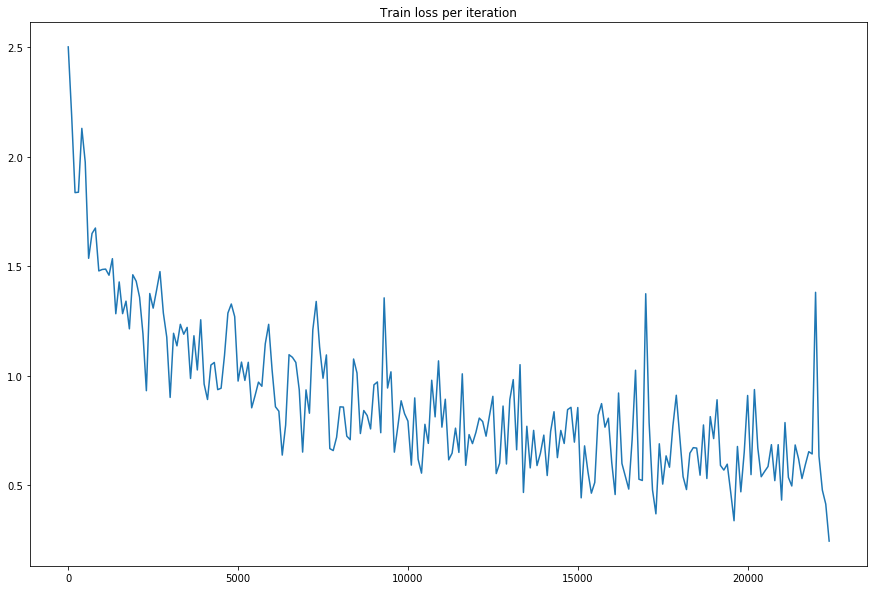

In [0]:
plt.figure(figsize=(15,10))
plt.title('Train loss per iteration')
plt.plot([i for i in range(0, len(train_loss)*100, 100)], train_loss)
plt.show()

# Third Run w/ BatchNorm & Dropout

In [0]:
# Hyper-parameters
val_every_epoch=True
use_batchnorm=True
learning_rate=0.009
early_stopping=100
batch_size=32
dropout_threshold=0.3
min_epochs = 15


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

layers_dims = [x_train.shape[0], 20, 7, 5, 10]

parameters, train_loss = L_layer_model(x_train, y_train, layers_dims, 999, learning_rate=learning_rate, early_stopping=early_stopping, use_batchnorm=use_batchnorm, batch_size=batch_size, dropout_threshold=dropout_threshold, min_epochs=min_epochs)

Epoch #1 in: 42s | train_loss: 2.27 - val_loss: 1.83 | train_acc: 19.73 - val_acc: 37.53
Epoch #2 in: 41s | train_loss: 1.9638 - val_loss: 1.6319 | train_acc: 27.75 - val_acc: 42.67
Epoch #3 in: 41s | train_loss: 1.8201 - val_loss: 1.4862 | train_acc: 31.13 - val_acc: 46.48
Epoch #4 in: 42s | train_loss: 1.7125 - val_loss: 1.388 | train_acc: 32.64 - val_acc: 46.78
Epoch #5 in: 42s | train_loss: 1.634 - val_loss: 1.3395 | train_acc: 33.83 - val_acc: 45.17
Epoch #6 in: 43s | train_loss: 1.5853 - val_loss: 1.309 | train_acc: 34.31 - val_acc: 47.56
Epoch #7 in: 45s | train_loss: 1.5574 - val_loss: 1.293 | train_acc: 34.51 - val_acc: 44.85
Epoch #8 in: 46s | train_loss: 1.5349 - val_loss: 1.2637 | train_acc: 35.15 - val_acc: 46.12
Epoch #9 in: 46s | train_loss: 1.5153 - val_loss: 1.2513 | train_acc: 36.04 - val_acc: 46.36
Epoch #10 in: 45s | train_loss: 1.5011 - val_loss: 1.2242 | train_acc: 36.32 - val_acc: 48.96
Epoch #11 in: 45s | train_loss: 1.5049 - val_loss: 1.2189 | train_acc: 36.48 

In [0]:
x_tr, x_val, y_tr, y_val = [elem.T for elem in train_test_split(x_train.T, y_train.T, test_size=0.2, random_state=seed)] # using same global seed
final_accs = np.array([Predict(data[0], data[1], parameters, use_batchnorm=use_batchnorm) for data in [(x_tr, y_tr), (x_val, y_val), (x_test, y_test)]])*100
print('Train Accuracy: {}% - Validation Accuracy: {}% - Test Accuracy: {}%'.format(*final_accs))

Train Accuracy: 60.81999999999999% - Validation Accuracy: 58.86% - Test Accuracy: 60.22%


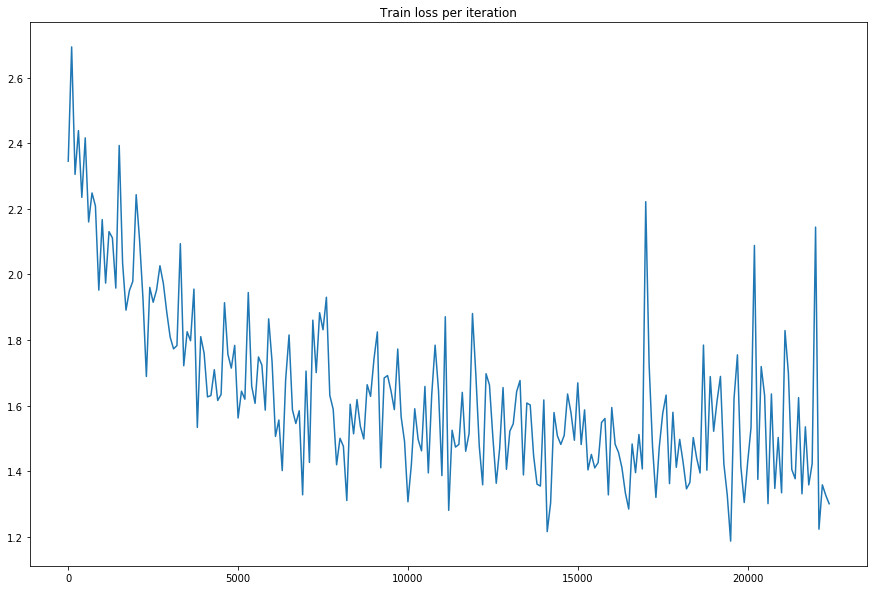

In [0]:
plt.figure(figsize=(15,10))
plt.title('Train loss per iteration')
plt.plot([i for i in range(0, len(train_loss)*100, 100)], train_loss)
plt.show()

# Fourth Run w/ Dropout only

In [0]:
# Hyper-parameters
val_every_epoch=True
use_batchnorm=False
learning_rate=0.009
early_stopping=100
batch_size=32
dropout_threshold=0.3
min_epochs = 15


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

layers_dims = [x_train.shape[0], 20, 7, 5, 10]

parameters_, train_loss_ = L_layer_model(x_train, y_train, layers_dims, 999, learning_rate=learning_rate, early_stopping=early_stopping, use_batchnorm=use_batchnorm, batch_size=batch_size, dropout_threshold=dropout_threshold, min_epochs=min_epochs)

Epoch #1 in: 35s | train_loss: 2.0954 - val_loss: 1.807 | train_acc: 20.56 - val_acc: 45.18
Epoch #2 in: 38s | train_loss: 1.8895 - val_loss: 1.5671 | train_acc: 30.0 - val_acc: 56.02
Epoch #3 in: 38s | train_loss: 1.7918 - val_loss: 1.4291 | train_acc: 31.66 - val_acc: 62.22
Epoch #4 in: 38s | train_loss: 1.749 - val_loss: 1.3468 | train_acc: 32.46 - val_acc: 67.31
Epoch #5 in: 38s | train_loss: 1.706 - val_loss: 1.2854 | train_acc: 33.39 - val_acc: 68.77
Epoch #6 in: 38s | train_loss: 1.6731 - val_loss: 1.2446 | train_acc: 35.52 - val_acc: 69.12
Epoch #7 in: 38s | train_loss: 1.6521 - val_loss: 1.2029 | train_acc: 37.5 - val_acc: 69.58
Epoch #8 in: 38s | train_loss: 1.6305 - val_loss: 1.1871 | train_acc: 38.79 - val_acc: 69.17
Epoch #9 in: 38s | train_loss: 1.6116 - val_loss: 1.1611 | train_acc: 39.48 - val_acc: 69.66
Epoch #10 in: 39s | train_loss: 1.6085 - val_loss: 1.159 | train_acc: 39.5 - val_acc: 69.72
Epoch #11 in: 38s | train_loss: 1.5974 - val_loss: 1.1375 | train_acc: 39.96

In [0]:
x_tr, x_val, y_tr, y_val = [elem.T for elem in train_test_split(x_train.T, y_train.T, test_size=0.2, random_state=seed)] # using same global seed
final_accs = np.array([Predict(data[0], data[1], parameters_, use_batchnorm=use_batchnorm) for data in [(x_tr, y_tr), (x_val, y_val), (x_test, y_test)]])*100
print('Train Accuracy: {}% - Validation Accuracy: {}% - Test Accuracy: {}%'.format(*final_accs))

Train Accuracy: 71.81% - Validation Accuracy: 71.07% - Test Accuracy: 71.03%


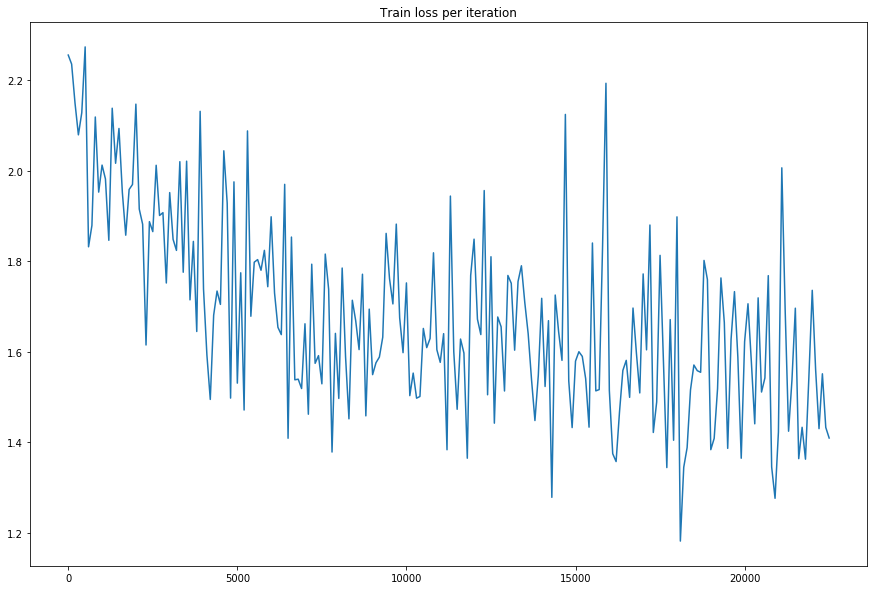

In [0]:
plt.figure(figsize=(15,10))
plt.title('Train loss per iteration')
plt.plot([i for i in range(0, len(train_loss_)*100, 100)], train_loss_)
plt.show()